In [3]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

# AE Model

In [35]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 11
hour = 21
month = 6
folder = "AE_No_rain_98"
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/temporal/models/model_{model_type}_{identifier}_{date_format}_final.pth"
config = torch.load(f'temporal/configs/config_{model_type}_{identifier}_{date_format}.pth', map_location=torch.device('cpu'))
model = AE(num_hiddens=config["num_hiddens"]).to(device)
# dataset_test = torch.load(f'temporal/datasets/dataset_test_ae_jaguas_9_70%.pth')
# dataset_train = torch.load(f'temporal/datasets/dataset_train_ae_jaguas_9_70%.pth')
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

y = torch.load(f"temporal/Features/{folder}/AE_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
X = torch.load(f"temporal/Features/{folder}/AE_features_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
y_path = torch.load(f"temporal/Features/{folder}/AE_test_path_samples_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
path_flat = [item for sublist in y_path for item in sublist]
path_flat = np.asarray(path_flat)
print(X.shape)
y["recorder"]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
Normalizer_ = Normalizer().fit(X)
X_norm = Normalizer_.transform(X)
PCA_ = PCA(n_components=60).fit(X_norm)
X_PCA = PCA_.transform(X_norm)
# X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
reducer = umap.UMAP(min_dist=0.9, n_components=60)
X_UMAP = reducer.fit_transform(X_norm)
X_batch = np.reshape(X_UMAP, (16964,5,X_UMAP.shape[1]))
# X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)


torch.Size([84820, 5184])


In [9]:
root_audios = f"{root}/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Complementary_Files/df_grabadoras_reg.csv"
root_clusters = f"{root}/temporal/clusters"
root_ai = f"{root}/Complementary_Files/Acoustic_Indices/AI_Jaguas.csv"
ecological_integrity = f"{root}/Complementary_Files/Indice_Integridad_Ecologica.xlsx"

audios = pd.read_csv(root_audios, index_col=0)
recorders = pd.read_csv(root_recorders)
ei  = pd.read_excel(ecological_integrity)
ai = pd.read_csv(root_ai)
ai.drop(columns=["Unnamed: 0"], inplace=True)
ai.drop(columns=["Date"], inplace=True)
ai.dropna(inplace=True)

ai.set_index("file",inplace=True, drop=True)
audios.set_index("Filename", inplace=True)

In [10]:
y_ = np.asarray(y_path)
y_2 = y_[:,0]
for i in range(len(y_2)):
    y_2[i] = y_2[i][0:-2] 
y_3 = list(y_2)

X_ai = []
remove = []
for i in range(len(y_3)):
    try:
        X_ai.append(ai.loc[y_3[i]])
#         print(i, " ", np.asarray(np.min(X_ai)))
    except:
        remove.append(y_3[i])
for i in range(len(remove)):
    y_3.remove(remove[i])
X_ai = np.asarray(X_ai)

labels_ai = []
# audios.set_index("Filename", inplace=True)
for i in range(len(y_3)):
    labels_ai.append(audios.loc[y_3[i], "Habitat"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ai, labels_ai, test_size=0.2,random_state=0)

In [ ]:
i = 75921
(X[i]==f[i//5][i%5]).all()

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# audios.set_index("Filename", inplace=True)
labels = []
for i in range(len(path_flat)):
    labels.append(audios.loc[path_flat[i][0:-2], "Habitat"])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2,random_state=0)

In [36]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_path, test_size=0.2,random_state=0)

X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])


labels_train = []
for i in range(len(y_train)):
    labels_train.append(audios.loc[y_train[i][0:-2], "Habitat"])
labels_test = []
for i in range(len(y_test)):
    labels_test.append(audios.loc[y_test[i][0:-2], "Habitat"])
    

In [ ]:
from sklearn import metrics

clf_svm = svm.SVC(kernel='rbf') # Linear Kernel
#Train the model using the training sets
clf_svm.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm = clf_svm.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=16, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)

Accuracy: 0.9049808429118774
f1: 0.875447735558784


In [ ]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(100), random_state=0)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_mlp))
print("f1:",metrics.f1_score(y_test, y_pred_mlp, average="macro"))

In [38]:
# f1_scores = [] # [ai, norm, PCA, UMAP]
# accuracies = []
f1_scores.append(f1_score)
accuracies.append(accuracy)

In [41]:
import pickle
with open("f1_scores", "wb") as fp:   #Pickling
    pickle.dump(f1_scores, fp)
    
with open("accuracies", "wb") as fp2:   #Pickling
    pickle.dump(accuracy, fp2)

FileNotFoundError: [Errno 2] No such file or directory: 'temporal/classification_results/calssification.pdf'

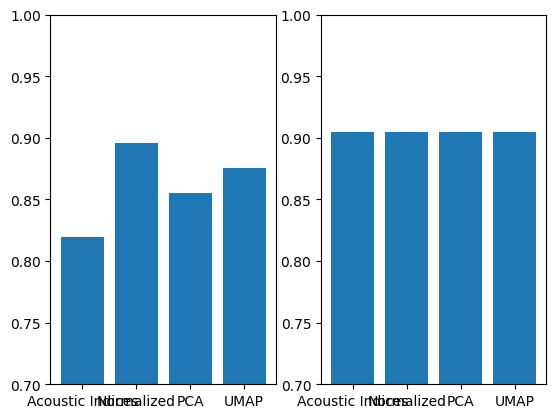

In [57]:
fig, ax = plt.subplots(1, 2)
ax[0].bar(["Acoustic Indices", "Normalized", "PCA", "UMAP"], f1_scores)
ax[0].set_ylim(0.7,1)
ax[1].bar(["Acoustic Indices", "Normalized", "PCA", "UMAP"], accuracy)
ax[1].set_ylim(0.7,1)
plt.savefig("temporal/classification_results/calssification.pdf", format="pdf")